NEEDED
- reference (here Salmo salar)

PROGRAMS
- bowtie2
- pysam


## External reference

In [9]:
import pysam
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline

In [10]:
salmo_FASTA = '/home/ipseg/Data/salmo/Ssa_ASM_3.6.fasta'

build bowtie2 index
 - printed because this take ~2 hours to run

In [11]:
print('bowtie2-build {} salmo'.format(salmo_FASTA))

bowtie2-build /home/ipseg/Data/salmo/Ssa_ASM_3.6.fasta salmo


## internal reference

In [12]:
chum_ref = '/media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta'

## Align

In [46]:
SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.SAM'
filtered_SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.filtered.SAM'

In [14]:
print('bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Data/salmo/salmo -U {} -S {}'.format(chum_ref, SAM_output))

bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Data/salmo/salmo -U /media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta -S /home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.SAM


## Examine alignments

### Reference genome (Salmo salar)

In [15]:
ref = pysam.FastaFile(salmo_FASTA)

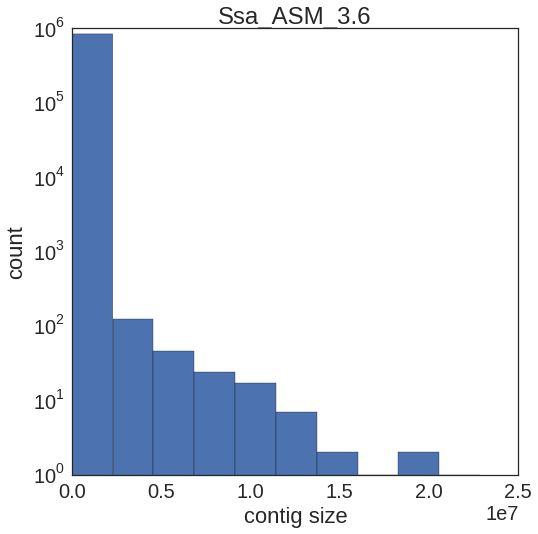

In [16]:
figsize(8,8)
plt.hist([ln for ln in ref.lengths])
plt.yscale('log', basey=10)
plt.ylabel('count')
plt.xlabel('contig size')
plt.title('Ssa_ASM_3.6')
plt.show()

#### Alignments to salmo

    

In [17]:
def get_aligns():
    return(pysam.AlignmentFile(SAM_output, "r").fetch())

In [18]:
mpqs = [read.mapping_quality for read in get_aligns()]

Looks like we have three types of alignments (tri-modal)
    - spurious (MQ < 2)
    - moderate support (10 < MQ < 28)
    - strong support (MQ > 30)

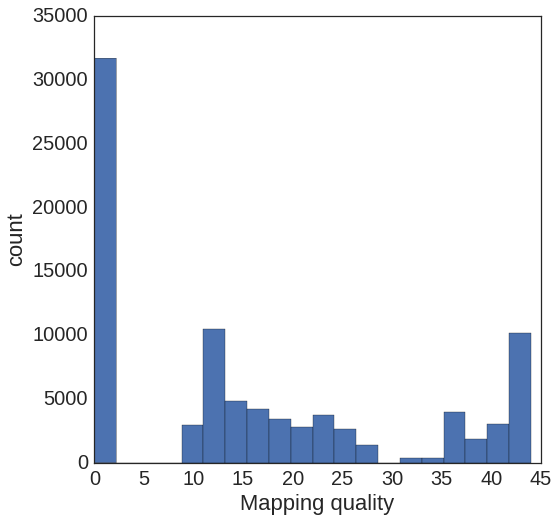

In [19]:
plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.show()

In [20]:
flags  = [read.flag for read in get_aligns()]

#### Flags 
* 4 = unmapped
* 16 = mapped to reverse strand

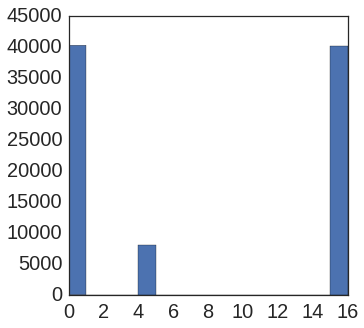

In [21]:
figsize(5,5)
plt.hist(flags, bins = 16)
plt.show()

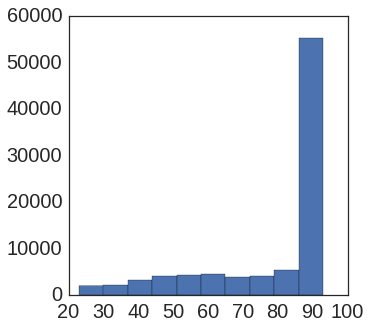

In [22]:
qal =  [read.query_alignment_length for read in get_aligns()]
plt.hist(qal)
plt.show()

#### Distribution of edit distances
held by tag 'XM'

In [23]:
edit_ditances = list()
mq = list()
for read in get_aligns():
    try:
        edit_ditances.append(np.int(read.get_tag('XM')))
        mq.append(np.int(read.mapping_quality))
    except KeyError:
        pass

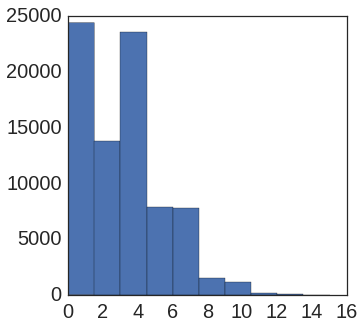

In [24]:
plt.hist(edit_ditances)
plt.show()

Edit distance does not tell the whole story. 
Low edit distances (<5) result in a braod range of mapping qualities.

In [25]:
rr = pd.DataFrame({'ed' : edit_ditances, 'mq' : mq })

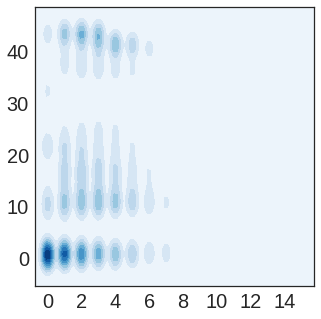

In [26]:
sns.kdeplot(rr, cmap="Blues", shade = True, legend = True)
plt.show()

#### Lets keep only the alignments with:
(query_alignment_length == 93) AND (mapping_quality >= 30)

In [47]:
with pysam.AlignmentFile(SAM_output, "r") as INFILE:
    with pysam.AlignmentFile(filtered_SAM_output, "wh", template=INFILE) as OUTFILE:
        for aln in INFILE:
            if (aln.query_alignment_length >= 93) and (aln.mapping_quality >= 30):
                OUTFILE.write(aln)

Which contigs are getting alignments?

#### convert SAM to BAM, sort and index BAM

In [48]:
BAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.filtered.BAM'
sorted_BAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.filtered.sorted.BAM'

In [49]:
!samtools view -bh {filtered_SAM_output} > {BAM_output}
!samtools sort -O bam -T temp {BAM_output} > {sorted_BAM_output}
!samtools index  {sorted_BAM_output}

In [50]:
!samtools idxstats {sorted_BAM_output} > \
'/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.coverage'

In [51]:
cov = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_salmo.coverage',
           sep = "\t", header = None)
cov.columns = ['contig', 'len', 'COV', 'UNK']
cov.head()

,contig,len,COV,UNK
0,ccf1000001392_0-0,45142,0,0
1,ccf1000000113_0-0,1375438,2,0
2,ccf1000001220_0-0,71750,0,0
3,ccf1000001280_0-0,62617,0,0
4,ccf1000000663_0-0,188506,0,0


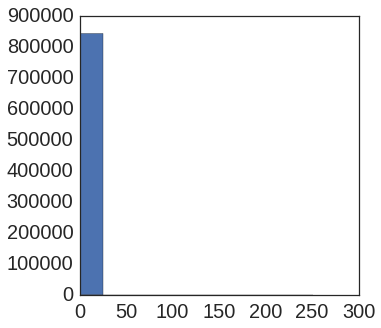

In [53]:
plt.hist(cov['COV'])

plt.show()

In [32]:
#pysam.AlignmentFile(sorted_BAM_output, "rb").count()

80319

In [54]:
ots_salmo = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/ots_salmo.txt', 
            sep = '\t', header = 0)
ots_salmo.head()

,Linkage Group,Ssa Genome Scaffold,Map Start (cM),Map End (cM),Scaffold Start (bp),Scaffold End (bp),Map Distance (bp),Scaffold Distance (bp),bp/cM,Loci Aligned,Orientation,Ssa Chromosomal Assignment
0,Ots01,jcf1000732633_0-0,4.71,4.71,256226,1164421,0.00,908195,NaN,3,NaN,Ssa23
1,Ots01,jcf1000298869_0-0,4.71,18.71,1055825,9091671,14.00,8035846,"573,989.00",21,-,Ssa23
2,Ots01,ccf1000000015_0-0,18.71,35.83,148475,8257101,17.12,8108626,"473,634.70",19,+,Ssa23
3,Ots01,ccf1000000022_0-0,36.14,54.50,296511,6626313,18.36,6329802,"344,760.46",17,-,NOT FOUND
4,Ots01,jcf1001138103_0-0,55.05,55.05,1134693,1931119,0.00,796426,NaN,3,NaN,Ssa23


In [ ]:
salmo_chr = ots_salmo[['Ssa Genome Scaffold', 'Ssa Chromosomal Assignment']]
salmo_chr.columns = ['contig', 'Ssa_chr']
ssa_cov = pd.merge(cov,salmo_chr)

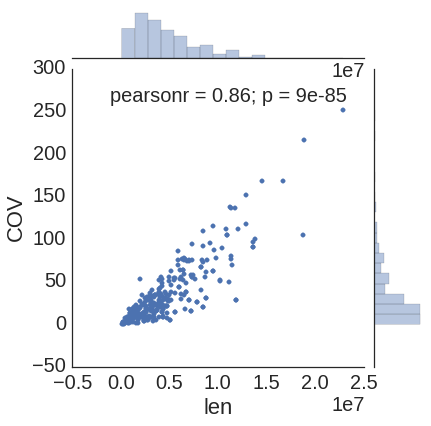

In [64]:
sns.jointplot('len', 'COV', data = ssa_cov,  
            #scatter_kws={"marker": ".", "color": "slategray"},
           #line_kws={"linewidth": 1, "color": "seagreen"}
             )
plt.show()